## Predict whether student will pass a course or not (K-NN, SVM, Bayes, Decision Tree, Decision Forest)

### Information about the dataset

- Number of inputs: **480**
- Number of variables: **17**
- Dataset: https://www.kaggle.com/aljarah/xAPI-Edu-Data
- Data fields description: https://www.kaggle.com/aljarah/xAPI-Edu-Data <br/>
Dataset has a range of features of a student that allow to predict a performance of a student

### Importing main libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
import warnings; warnings.simplefilter('ignore')

### Importing the dataset


In [42]:
dataset = pd.read_csv('xAPI-Edu-Data.csv')

<b>Changing last column that corresponds to a mark. High and Middle - passing marks, Low is a fail</b>

In [43]:
dataset.iloc[:, -1] = dataset.iloc[:, -1].map({'H': 1, 'M': 1, 'L': 0})

<b>9,10,11,12 - are continious columns that will be used to build k-nn, svm, decision tree</b> <br>
9 Raised hand- how many times the student raises his/her hand on classroom (numeric:0-100)<br>
10 Visited resources- how many times the student visits a course content(numeric:0-100)<br>
11 Viewing announcements-how many times the student checks the new announcements(numeric:0-100)<br>
12 Discussion groups- how many times the student participate on discussion groups (numeric:0-100)

In [44]:
X = dataset.iloc[:, [9, 10 , 11, 12]].values#.astype(float)
y = dataset.iloc[:, 16].values#.astype(float)

### Selecting columns to work with
Two approaches will be used to select a required range of variables for machine learning algorithm. These approaches are "Backward Elimination" and "Forward selection": https://en.wikipedia.org/wiki/Stepwise_regression

Lets start with <b>Backward Elimination<b>:

In [45]:
import statsmodels.formula.api as sm

p=0.05

#imputs for def are: X, y and p-value
def BackwardElimination(merged_dataset, y, p):
    #merged_dataset = np.append(arr = np.ones((np.size(merged_dataset,0),1)).astype(int), values=merged_dataset, axis=1) #np.size(merged_categ,0) - number of rows in numpy array
    #this adds our dataset to a column of one so ones are in the first column (for linear regression)

    #number of columns
    len_list = []                                 #list of indexes of all columns
    for i in range(np.size(merged_dataset,1)+1):
        len_list.append(i)

    
    p = p #p-value for; can be adjusted depending on desired result (default - 0.05)

    end = False
    while end==False:
        regressor_OLS = sm.OLS(endog = y, exog = merged_dataset).fit()
        p_values = regressor_OLS.pvalues
        #enable these prints to see a process of selection in a real time
        #print("P values are: "+str(['%.3f' % i for i in p_values.tolist()]))
        #print("Max p value: "+str(max(p_values)))
        #print("==============================================")
        if max(p_values)<p:
            end = True
            return merged_dataset
        elif max(p_values)>=p:
            p_max_pos = p_values.tolist().index(max(p_values))
            merged_dataset = np.delete(merged_dataset, [p_max_pos], axis=1)

X = BackwardElimination(X, y, p)

### Building a K-NN model using PramGrid (Backward Elimination) 

In [46]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

<b>Feature Scaling </b>

In [47]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#sc_y = StandardScaler()
#y_train = sc_y.fit_transform(y_train.reshape(-1, 1))
#y_test = sc_y.fit_transform(y_test.reshape(-1, 1))


<b>Fitting a model</b>

In [48]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = range(1,10)

param_grid = dict(n_neighbors=n_neighbors)

from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

In [49]:
print('Grid best parameter (max. accuracy): ', grid_search.best_params_)

Grid best parameter (max. accuracy):  {'n_neighbors': 7}


Train score

In [50]:
grid_search.score(X_train, y_train)

0.8944444444444445

Test score

In [51]:
grid_search.score(X_test, y_test)

0.9083333333333333

### Evaluating a model

<b>Cross validation: precision, accuracy, recall and f1<b>


In [52]:
from sklearn.model_selection import cross_val_score
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.85123967 0.88333333 0.85714286]
Precision: [0.9382716  0.89473684 0.8988764 ]
Recall: [0.85393258 0.95505618 0.90909091]
F1: [0.89411765 0.92391304 0.9039548 ]


<b>Building a Confusion Metrics<b>

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[27,  6],
       [ 5, 82]], dtype=int64)

<b>109</b> were predicted right, while <b>11</b> were predicted wrong. 109/120 = <b>0.91</b>

 For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [54]:
from sklearn.metrics import precision_score
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.07


AUC score

In [55]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.88


<b>Adding results to a table for summarization in the end</b>

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



model_name=[]
accuracy_col=[]
precision_col=[]
recall_col=[]
f1_col=[]
auc_col=[]

model_name.append("Backward/KNN")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>

<IPython.core.display.Javascript object>


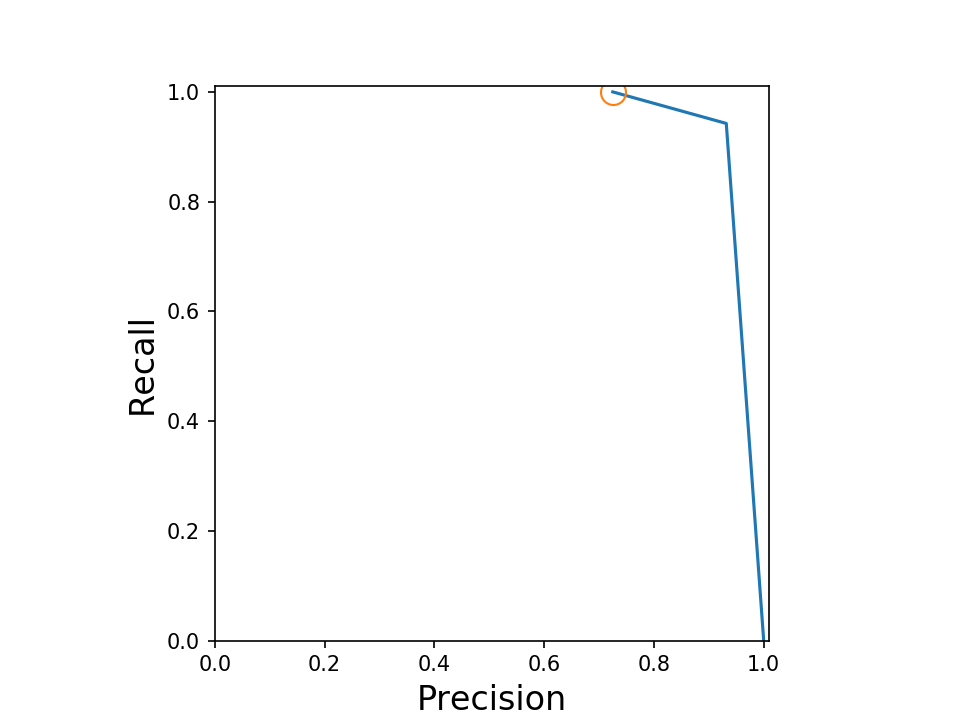

In [57]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>

<IPython.core.display.Javascript object>


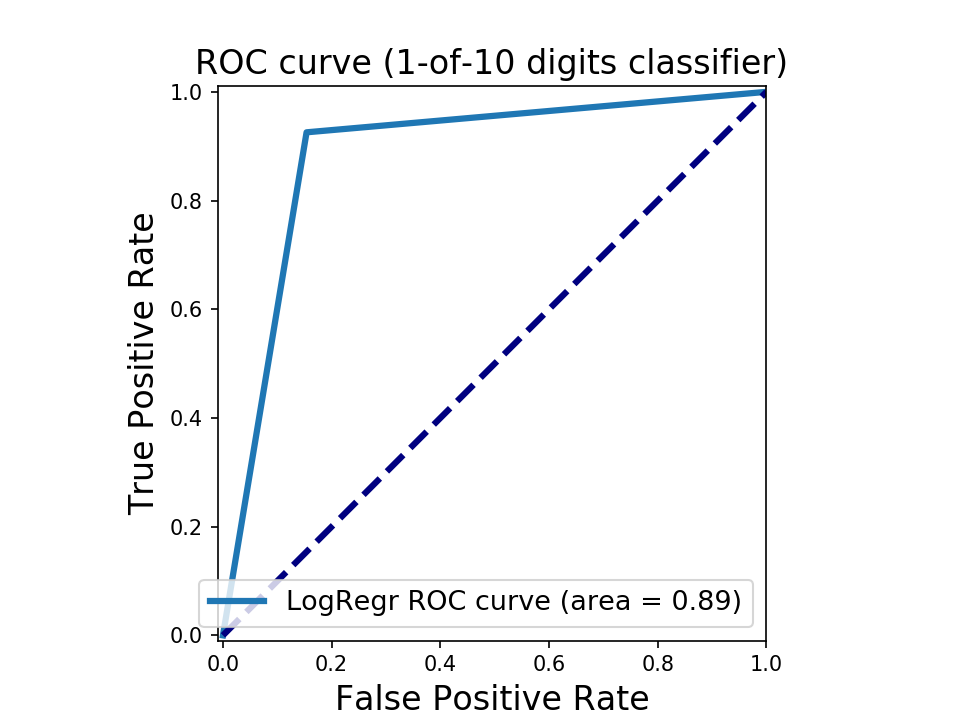

In [58]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a Naive Bayes model using PramGrid (Backward Elimination) 


<b>Fitting a model</b>


In [59]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

Train score

In [60]:
classifier.score(X_train, y_train)

0.8555555555555555

Test score

In [61]:
classifier.score(X_test, y_test)

0.8833333333333333

### Evaluating a model

<b>Cross validation: precision, accuracy, recall and f1<b>

In [62]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.85950413 0.85833333 0.8487395 ]
Precision: [0.9375     0.94805195 0.925     ]
Recall: [0.86206897 0.84883721 0.86046512]
F1: [0.89820359 0.89570552 0.89156627]



<b>Building a Confusion Metrics<b>







In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[25,  1],
       [13, 81]], dtype=int64)

<b>106</b> were predicted right, while <b>14</b> were predicted wrong. 106/120 = <b>0.88</b>


For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>


In [64]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.01


AUC score

In [65]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.91


<b>Adding results to a table for summarization in the end</b>

In [66]:
model_name.append("Backward/Bayes")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>

<IPython.core.display.Javascript object>


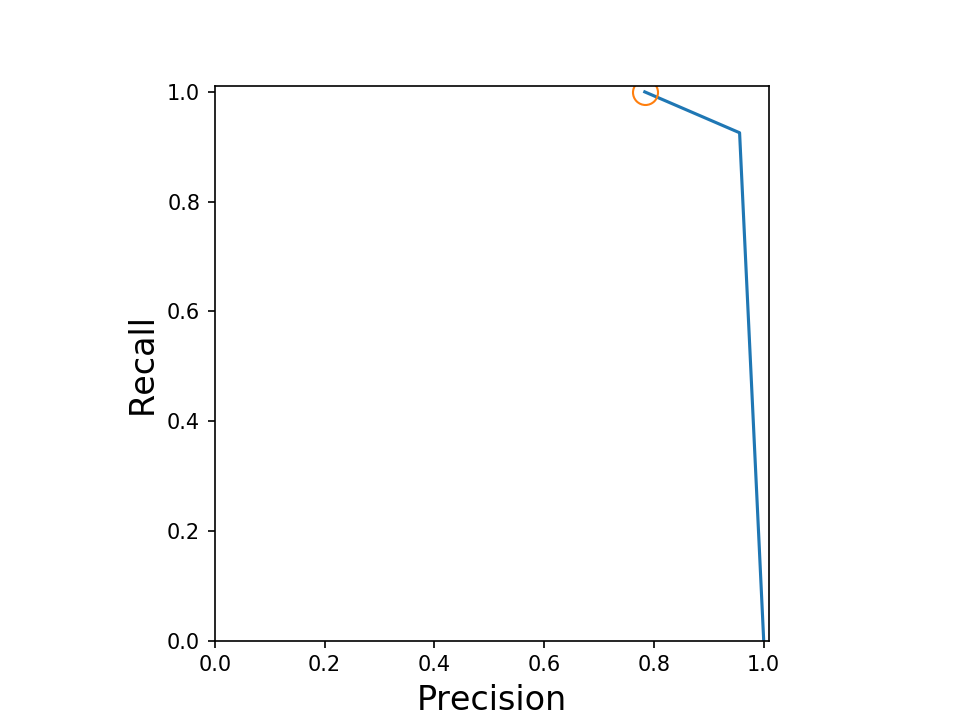

In [67]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>

<IPython.core.display.Javascript object>


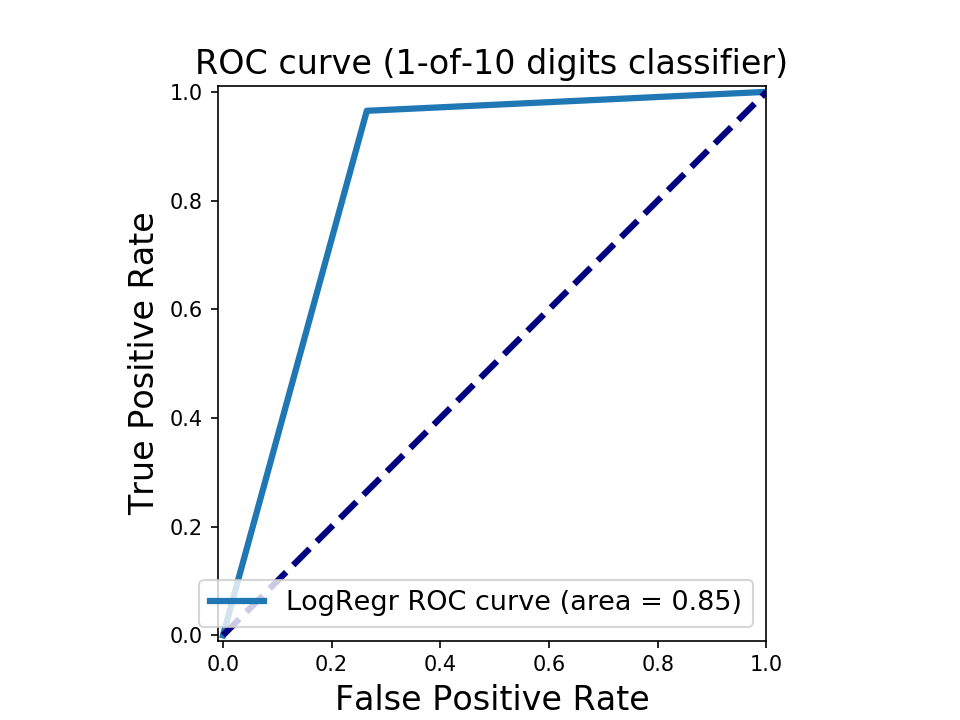

In [68]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a SVC model using PramGrid (Backward Elimination) 

<b>Fitting a model</b>

In [69]:
from sklearn.svm import SVC

Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10]
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2] 
param_grid = dict(gamma=gammas, C=Cs)

from sklearn.model_selection import GridSearchCV
svc = SVC(kernel = 'rbf', random_state = 0)
grid_search = GridSearchCV(svc, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

In [70]:
print('Grid best parameter (max. accuracy): ', grid_search.best_params_)

Grid best parameter (max. accuracy):  {'C': 10, 'gamma': 0.001}


Train score

In [71]:
grid_search.score(X_train, y_train)

0.9055555555555556

Test score

In [72]:
grid_search.score(X_test, y_test)

0.9

### Evaluating a model

<b>Cross validation: precision, accuracy, recall and f1<b>


In [73]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.8        0.9        0.81666667]
Precision: [0.90123457 0.91397849 0.89411765]
Recall: [0.82022472 0.95505618 0.85393258]
F1: [0.85882353 0.93406593 0.87356322]


<b>Building a Confusion Metrics<b>


In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[25,  9],
       [ 3, 83]], dtype=int64)

<b>108</b> were predicted right, while <b>14</b> were predicted wrong. 108/120 = <b>0.86</b>

For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [75]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.10


AUC score


In [76]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.85


<b>Adding results to a table for summarization in the end</b>


In [77]:
model_name.append("Backward/SVC")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>

<IPython.core.display.Javascript object>


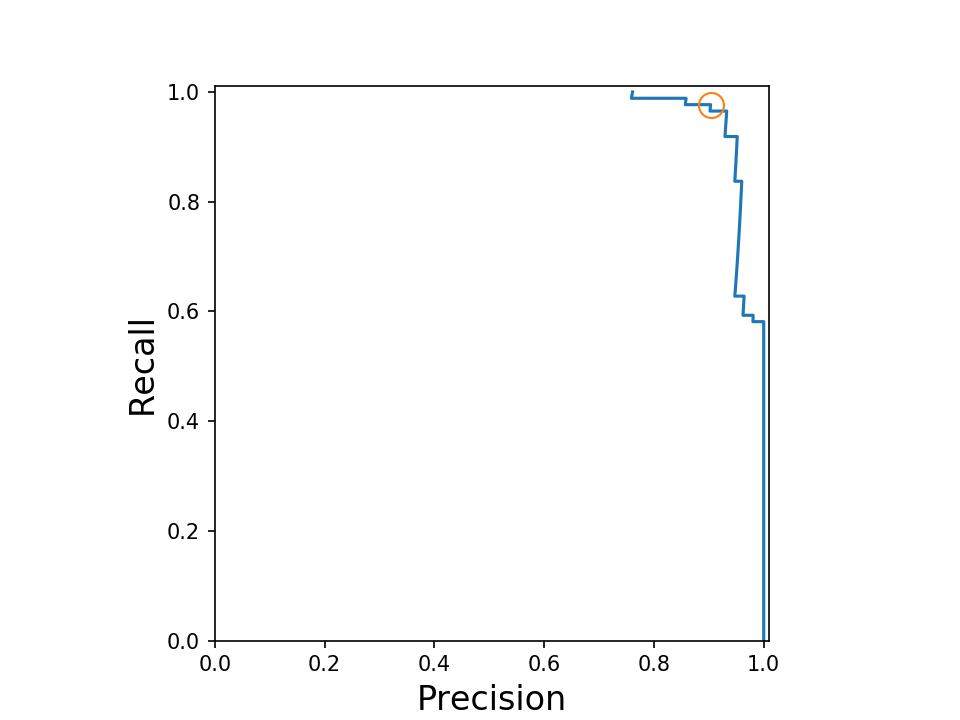

In [78]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).decision_function(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>

<IPython.core.display.Javascript object>


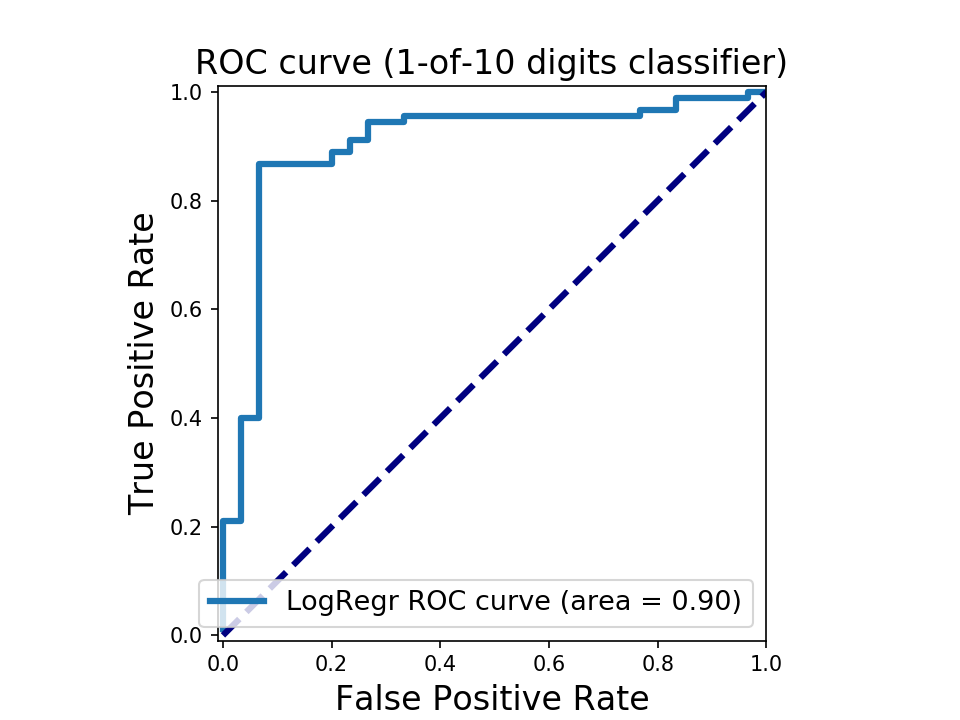

In [79]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a Decision Tree model using PramGrid (Backward Elimination) 

In [80]:
max_depth = np.linspace(1, 40, 40, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
criterion = ['entropy', 'gini']

param_grid = dict(max_depth=max_depth, 
                  min_samples_split = min_samples_splits,
                  min_samples_leaf = min_samples_leafs,
                  criterion=criterion)

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(classifier, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train)

grid_search.predict(X_test)


print('Grid best parameter (max. accuracy): ', grid_search.best_params_)
y_pred = grid_search.predict(X_test)

Grid best parameter (max. accuracy):  {'criterion': 'gini', 'max_depth': 1.0, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}


Train score





In [81]:
grid_search.score(X_train, y_train)

0.8638888888888889

Test score


In [82]:
grid_search.score(X_test, y_test)

0.8166666666666667

### Evaluating a model



<b>Cross validation: precision, accuracy, recall and f1<b>

In [83]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.85950413 0.84166667 0.86554622]
Precision: [0.89010989 0.91566265 0.9382716 ]
Recall: [0.92045455 0.86363636 0.87356322]
F1: [0.90502793 0.88888889 0.9047619 ]


<b>Building a Confusion Metrics<b>


In [84]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[23,  7],
       [15, 75]], dtype=int64)

<b>100</b> were predicted right, while <b>22</b> were predicted wrong. 100/120 = <b>0.825</b>


For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [90]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.26


AUC score


In [86]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.80


<b>Adding results to a table for summarization in the end</b>


In [87]:
model_name.append("Backward/Decision Tree")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>

<IPython.core.display.Javascript object>


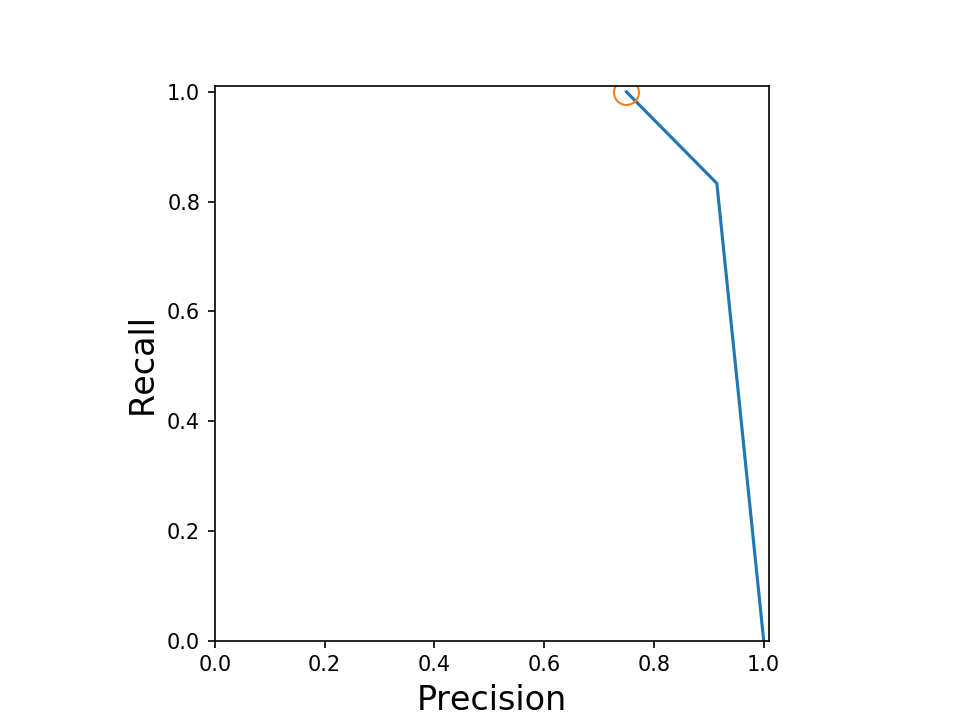

In [88]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>

<IPython.core.display.Javascript object>


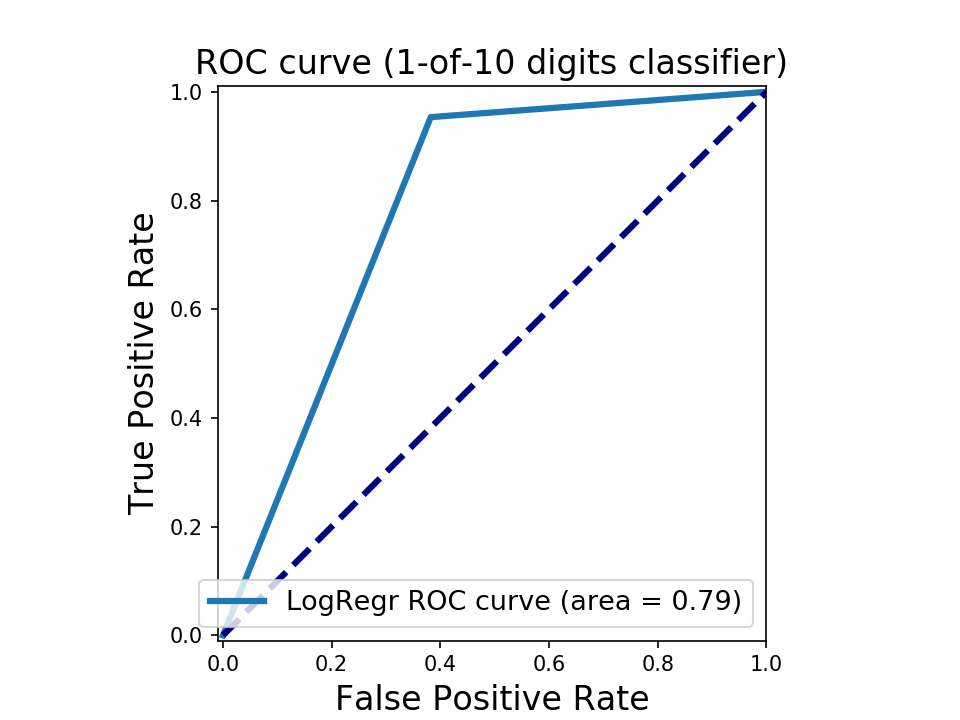

In [89]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a Random Forest model using PramGrid (Backward Elimination) 

In [91]:
from sklearn.ensemble import RandomForestClassifier

max_depth = np.linspace(1, 40, 40, endpoint=True)
n_estimators = [5,10,15,20,30]
criterion = ['entropy', 'gini']

param_grid = dict(max_depth=max_depth, 
                  n_estimators = n_estimators,
                 criterion=criterion)

#model
from sklearn.model_selection import GridSearchCV
forest = RandomForestClassifier()
grid_search = GridSearchCV(forest, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train.ravel())

y_pred = grid_search.predict(X_test)

Train score


In [92]:
grid_search.score(X_train, y_train)

0.8888888888888888

Test score

In [93]:
grid_search.score(X_test, y_test)

0.8666666666666667

### Evaluating a model


<b>Cross validation: precision, accuracy, recall and f1<b>


In [95]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.85833333 0.875      0.84166667]
Precision: [0.87234043 0.875      0.91860465]
Recall: [0.95505618 0.94382022 0.87640449]
F1: [0.8972973  0.91891892 0.89772727]


<b>Building a Confusion Metrics<b>

In [96]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[23, 11],
       [ 5, 81]], dtype=int64)

<b>104</b> were predicted right, while <b>16</b> were predicted wrong. 104/120 = <b>0.85</b>


For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [97]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.12


AUC score


In [98]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.81


<b>Adding results to a table for summarization in the end</b>


In [99]:
model_name.append("Backward/Random Forest")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>


<IPython.core.display.Javascript object>


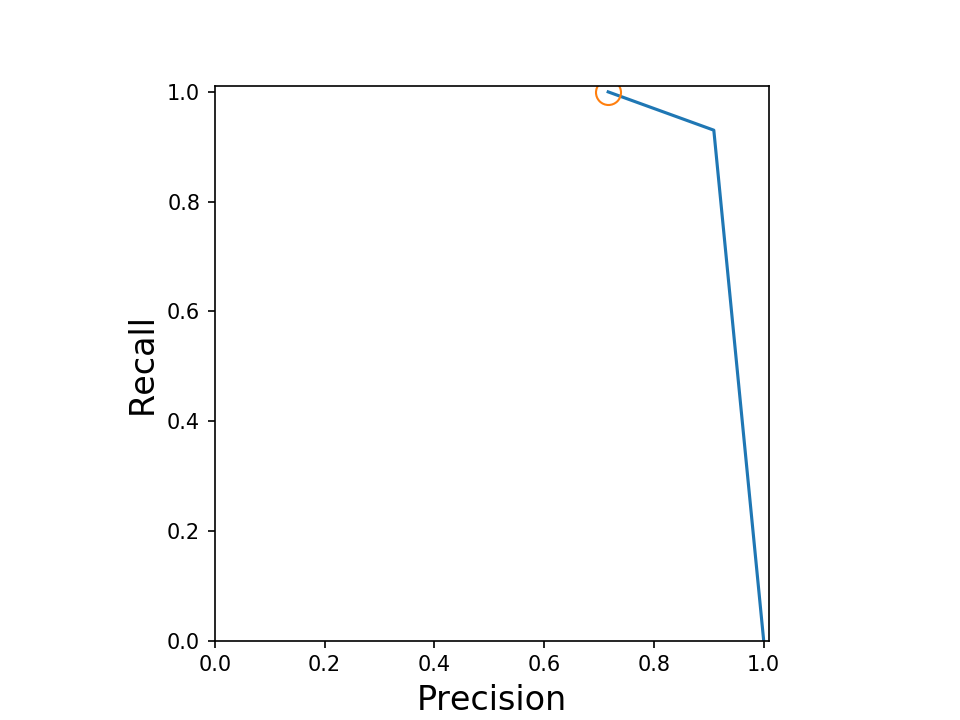

In [100]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>


<IPython.core.display.Javascript object>


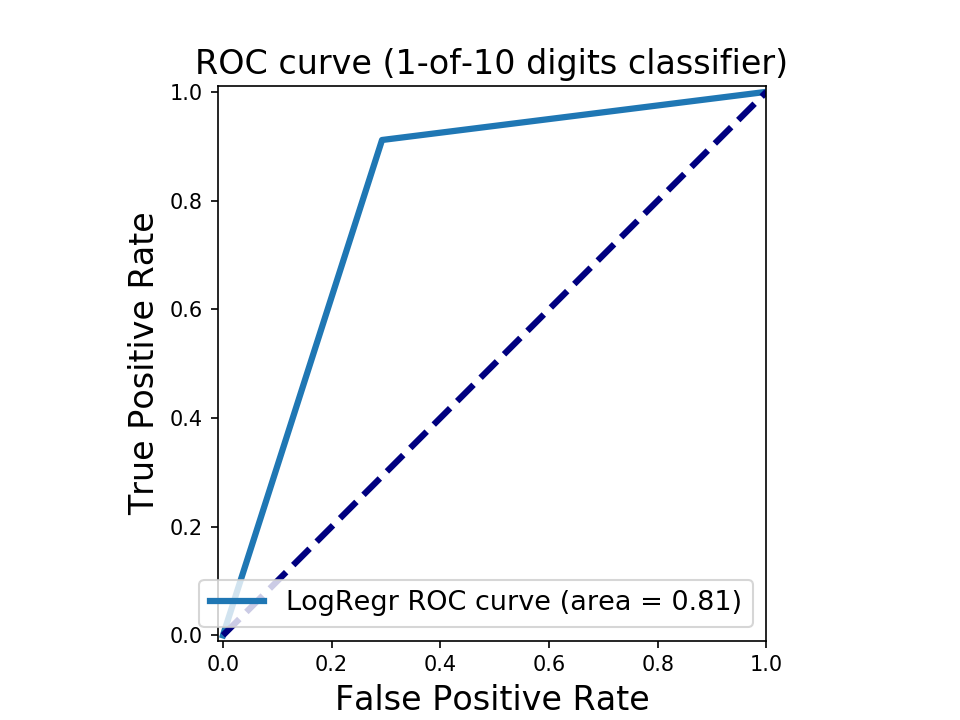

In [101]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Lets apply Forward Selection now:


In [102]:
import statsmodels.formula.api as sm

def ForwardSelection(merged_dataset, y, p):
    unknown_variables = []                  #a list of variables that are not included as "good" ones; after each iteration some variable dissapears from "unknown" and becomes "good"
    for i in range(merged_dataset.shape[1]):
        unknown_variables.append(i)
    
    #adding b0 variable from formula
    #merged_dataset = np.append(arr = np.ones((np.size(merged_dataset,0),1)).astype(int), values=merged_dataset, axis=1) #np.size(merged_categ,0) - number of rows in numpy array
    p = p
    
    ###first iteration is added separately, others in a loop below
    p_values_list=[]
    good_variables=[]
    for i in range(merged_dataset.shape[1]):
        X_opt = merged_dataset[:, i]
        regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()   #finding p value of every variable and y(the variable to predict)
        p_value = regressor_OLS.pvalues
        p_values_list.extend(p_value.tolist())
    min_p_value = min(p_values_list)                            #finding the minimum p value
    min_index = p_values_list.index(min_p_value)                #variable with the smallest p value
    good_variables.append(min_index)                            #add a variable to a "good" list
    unknown_variables.remove(min_index)                         #remove index from a list of "bad" variables
    
    end=False
    while end==False:
        comb_list = []
        p_values_list=[]
        
        #this loop exists to make combinations of "good" variables with every "unknown" to find p value of every combination
        for i in unknown_variables:                            
            temp_list = []
            for t in good_variables:
                temp_list.append(t)
            temp_list.append(i)
            comb_list.append([temp_list])
            #print(temp_list)
        for el in comb_list:
            X_opt = merged_dataset[:, el[0]]
            regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
            p_value = regressor_OLS.pvalues
            pvalue_lst = p_value.tolist()
            p_values_list.append(pvalue_lst[-1])
        #finding combination with min p value
        min_p_value = min(p_values_list)                            
        min_index = p_values_list.index(min_p_value)
        good_variables.append(comb_list[min_index][-1][-1])
        unknown_variables.remove(comb_list[min_index][-1][-1])
        #uncomment to see every step
        #print("Min p value: "+str(min_p_value))
        #print("List of variables: "+str(good_variables))
        #print("####################################")
        if min_p_value>p:
             end=True
        
    #print("UN: "+str(unknown_variables))
    print("GN: "+str(good_variables))
    return merged_dataset[:, good_variables]

In [103]:
p = 0.05
X = dataset.iloc[:, [9, 10 , 11, 12]].values
y = dataset.iloc[:, 16].values
X = ForwardSelection(X, y, p)

GN: [1, 3, 0, 2]


### Building a K-NN model using PramGrid (Forward Selection) 


In [104]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

<b>Feature Scaling </b>

In [105]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#sc_y = StandardScaler()
#y_train = sc_y.fit_transform(y_train.reshape(-1, 1))
#y_test = sc_y.fit_transform(y_test.reshape(-1, 1))

<b>Fitting a model</b>


In [106]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = range(1,10)

param_grid = dict(n_neighbors=n_neighbors)

from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Grid best parameter (max. accuracy): ', grid_search.best_params_)

Grid best parameter (max. accuracy):  {'n_neighbors': 7}


Train score





In [107]:
grid_search.score(X_train, y_train)

0.8833333333333333

Test score


In [108]:
grid_search.score(X_test, y_test)

0.875

### Evaluating a model

<b>Cross validation: precision, accuracy, recall and f1<b>

In [109]:
from sklearn.model_selection import cross_val_score
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.82644628 0.85       0.87394958]
Precision: [0.89534884 0.86597938 0.93975904]
Recall: [0.86516854 0.94382022 0.88636364]
F1: [0.88       0.90322581 0.9122807 ]


<b>Building a Confusion Metrics<b>

In [110]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[23, 10],
       [ 5, 82]], dtype=int64)

<b>105</b> were predicted right, while <b>15</b> were predicted wrong. 105/120 = <b>0.875</b>

 For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [111]:
from sklearn.metrics import precision_score
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.11


AUC score


In [112]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.82


<b>Adding results to a table for summarization in the end</b>


In [113]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

model_name.append("Forward/KNN")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>

<IPython.core.display.Javascript object>


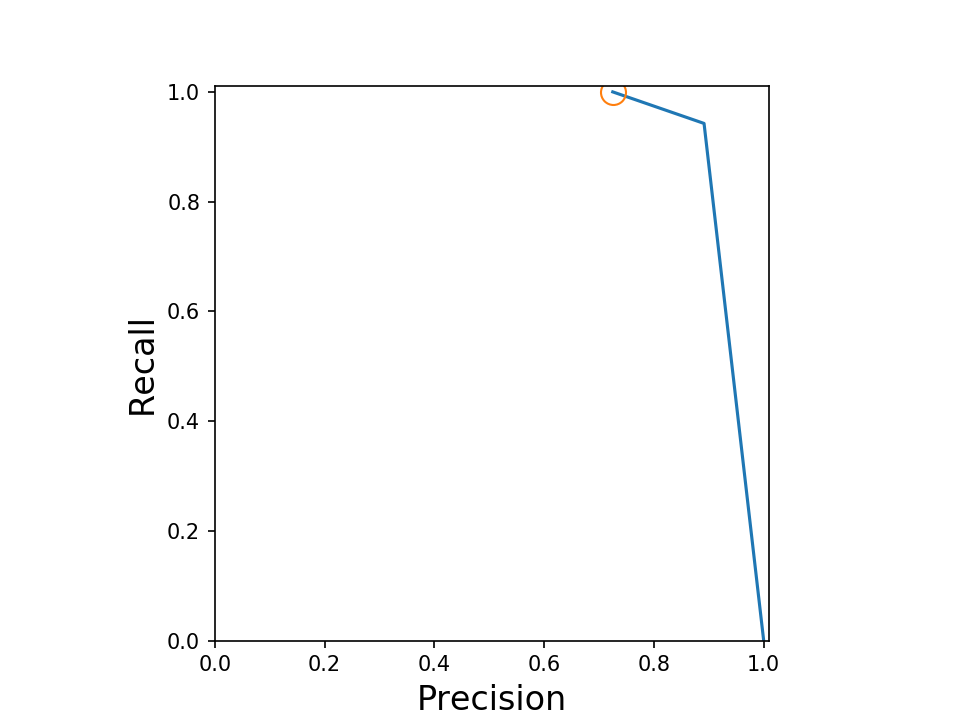

In [114]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>

<IPython.core.display.Javascript object>


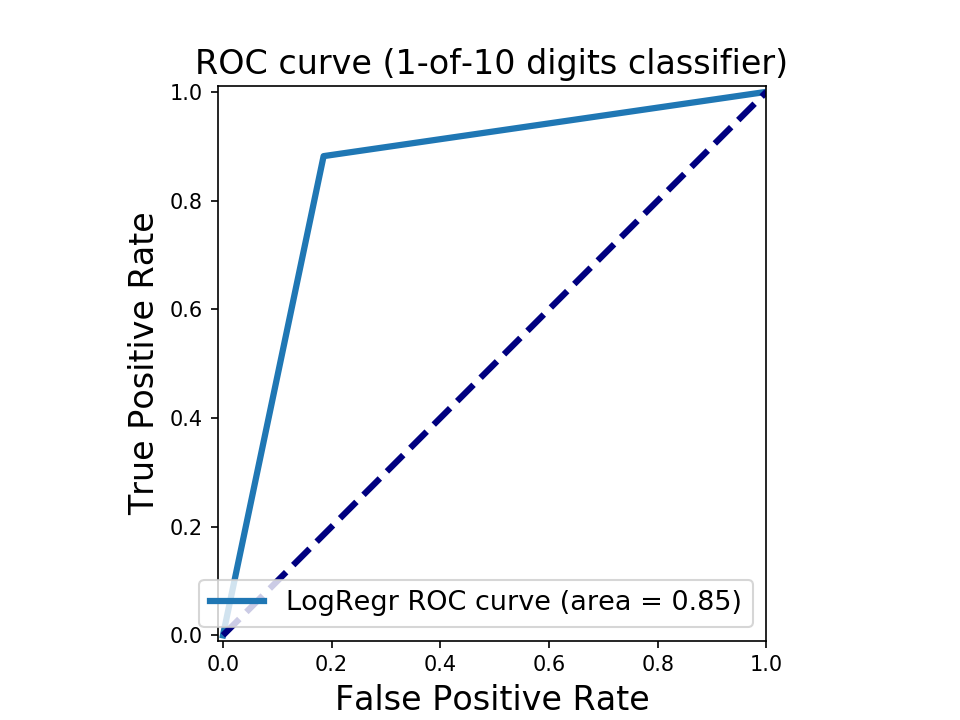

In [115]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a Naive Bayes model using PramGrid (Forward Selection) 

<b>Fitting a model</b>

In [116]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

Train score

In [117]:
classifier.score(X_train, y_train)

0.8555555555555555

Test score

In [118]:
classifier.score(X_test, y_test)

0.875

### Evaluating a model

<b>Cross validation: precision, accuracy, recall and f1<b>

In [119]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(classifier, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.82644628 0.83333333 0.87394958]
Precision: [0.875      0.90361446 1.        ]
Recall: [0.88505747 0.86206897 0.8255814 ]
F1: [0.88       0.88235294 0.9044586 ]


<b>Building a Confusion Metrics<b>

In [120]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[27,  0],
       [15, 78]], dtype=int64)

<b>105</b> were predicted right, while <b>15</b> were predicted wrong. 102/120 = <b>0.86</b>

For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>









In [121]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.00


AUC score


In [122]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.92


<b>Adding results to a table for summarization in the end</b>


In [123]:
model_name.append("Forward/Bayes")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>




<IPython.core.display.Javascript object>


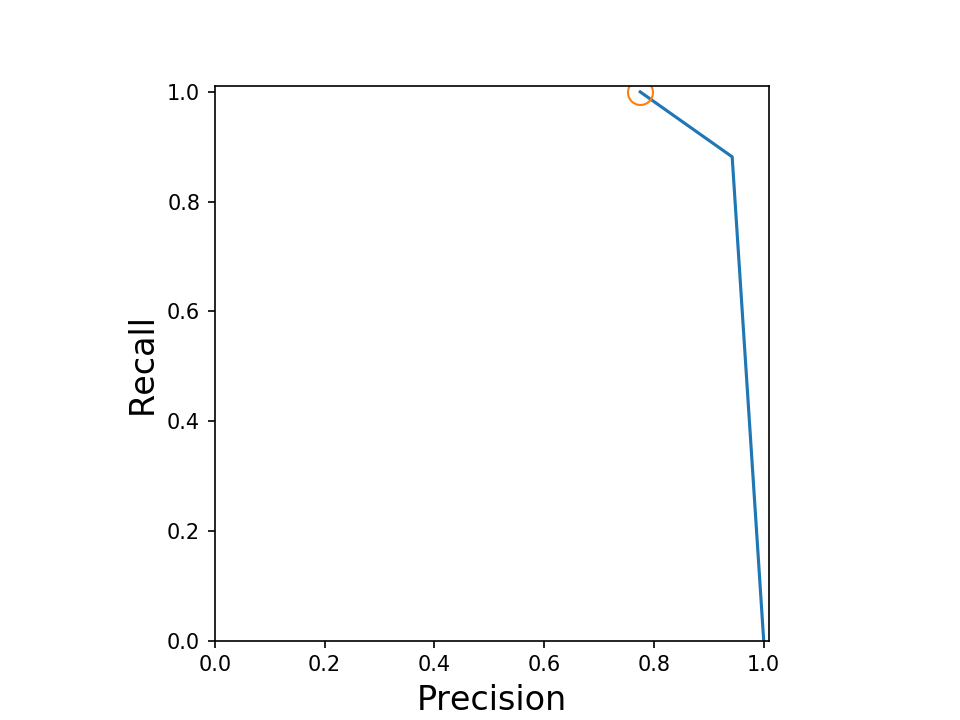

In [124]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>


<IPython.core.display.Javascript object>


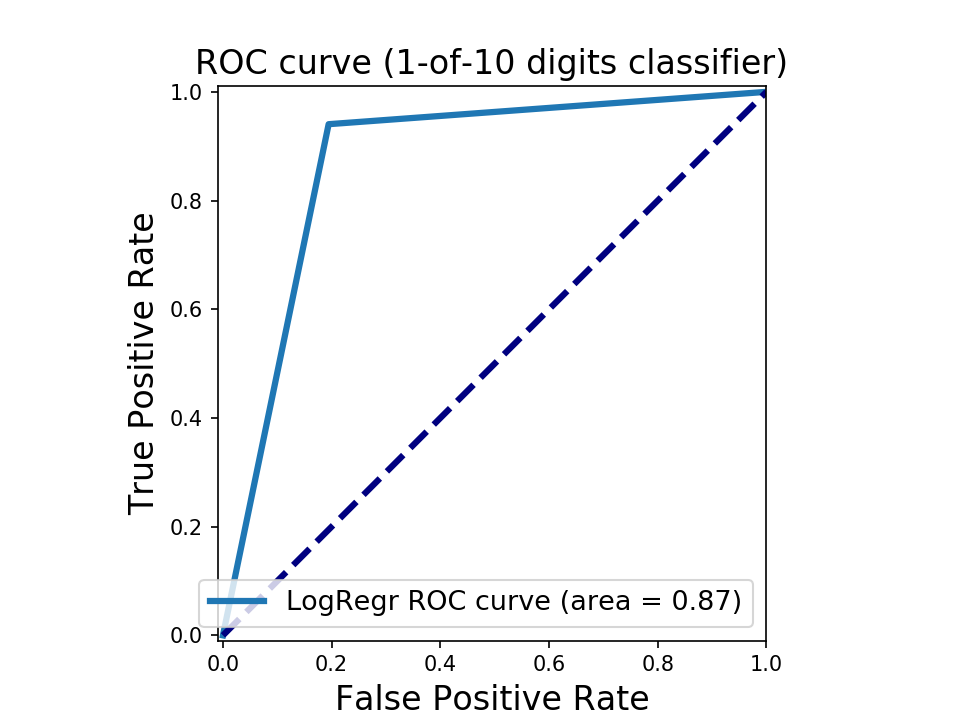

In [125]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a SVC model using PramGrid (Forward Selection) 

<b>Fitting a model</b>

In [126]:
from sklearn.svm import SVC

Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10]
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 2] 
param_grid = dict(gamma=gammas, C=Cs)

from sklearn.model_selection import GridSearchCV
svc = SVC(kernel = 'rbf', random_state = 0)
grid_search = GridSearchCV(svc, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Grid best parameter (max. accuracy): ', grid_search.best_params_)

Grid best parameter (max. accuracy):  {'C': 1, 'gamma': 0.0001}


Train score

In [127]:
grid_search.score(X_train, y_train)

0.8666666666666667

Test score

In [128]:
grid_search.score(X_test, y_test)

0.875

### Evaluating a model

<b>Cross validation: precision, accuracy, recall and f1<b>

In [129]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.85950413 0.85833333 0.88235294]
Precision: [0.86868687 0.93975904 0.91208791]
Recall: [0.95555556 0.86666667 0.93258427]
F1: [0.91005291 0.9017341  0.92222222]


<b>Building a Confusion Metrics<b>


In [130]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[26, 10],
       [ 5, 79]], dtype=int64)

<b>105</b> were predicted right, while <b>15</b> were predicted wrong. 101/120 = <b>0.85</b>

For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [131]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.11


AUC score

In [132]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.83


<b>Adding results to a table for summarization in the end</b>

In [133]:
model_name.append("Forward/SVC")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>

<IPython.core.display.Javascript object>


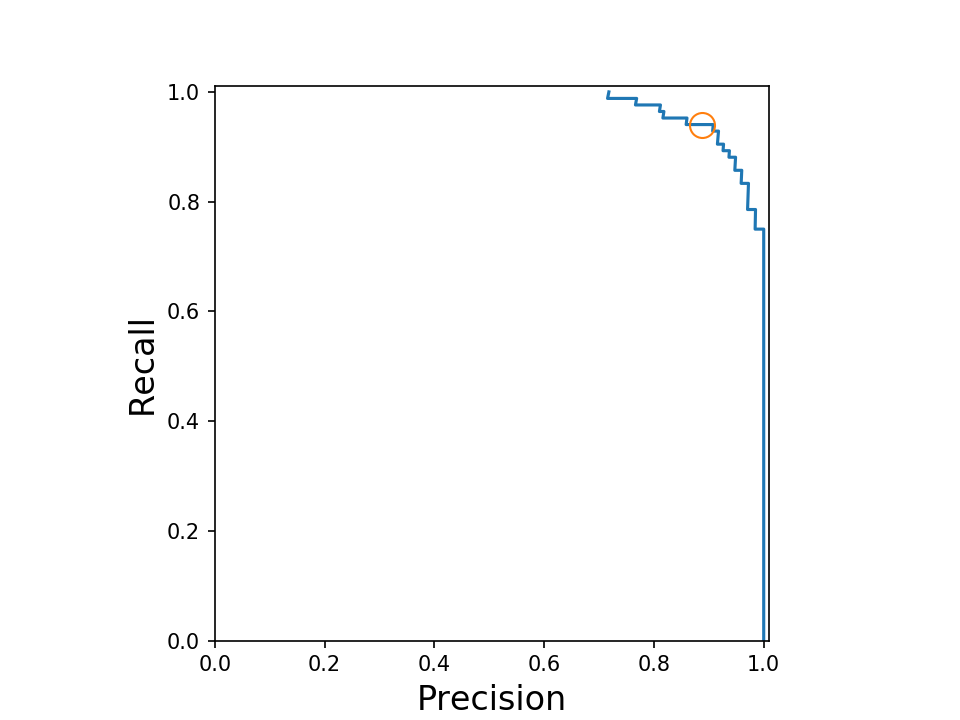

In [134]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).decision_function(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>


<IPython.core.display.Javascript object>


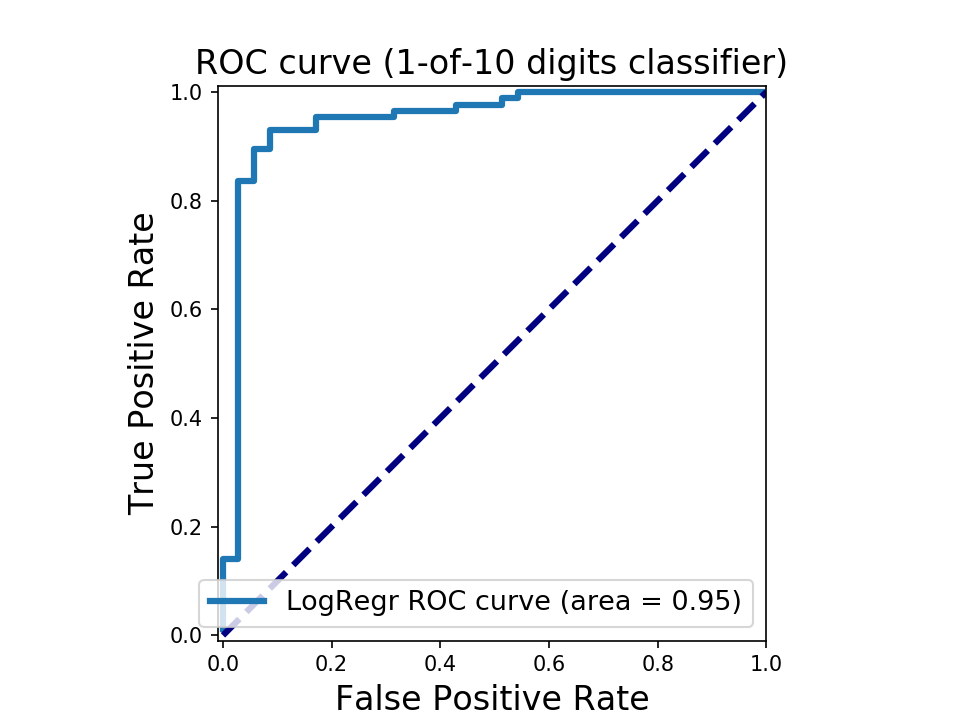

In [135]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a Decision Tree model using PramGrid (Forward Selection) 


In [136]:
max_depth = np.linspace(1, 40, 40, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
criterion = ['entropy', 'gini']

param_grid = dict(max_depth=max_depth, 
                  min_samples_split = min_samples_splits,
                  min_samples_leaf = min_samples_leafs,
                  criterion=criterion)

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
grid_search = GridSearchCV(classifier, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train)

grid_search.predict(X_test)


print('Grid best parameter (max. accuracy): ', grid_search.best_params_)

y_pred = grid_search.predict(X_test)

Grid best parameter (max. accuracy):  {'criterion': 'gini', 'max_depth': 1.0, 'min_samples_leaf': 0.30000000000000004, 'min_samples_split': 0.1}


Train score


In [137]:
grid_search.score(X_train, y_train)

0.8444444444444444

Test score

In [138]:
grid_search.score(X_test, y_test)

0.85

### Evaluating a model


<b>Cross validation: precision, accuracy, recall and f1<b>

In [139]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.84297521 0.85       0.80672269]
Precision: [0.89010989 0.90804598 0.94594595]
Recall: [0.9        0.88764045 0.78651685]
F1: [0.89502762 0.89772727 0.85889571]


<b>Building a Confusion Metrics<b>

In [140]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[28,  7],
       [11, 74]], dtype=int64)

<b>102</b> were predicted right, while <b>18</b> were predicted wrong. 105/120 = <b>0.85</b>

For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [141]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.09


AUC score


In [142]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.84


<b>Adding results to a table for summarization in the end</b>

In [143]:
model_name.append("Forward/Decision Tree")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>


<IPython.core.display.Javascript object>


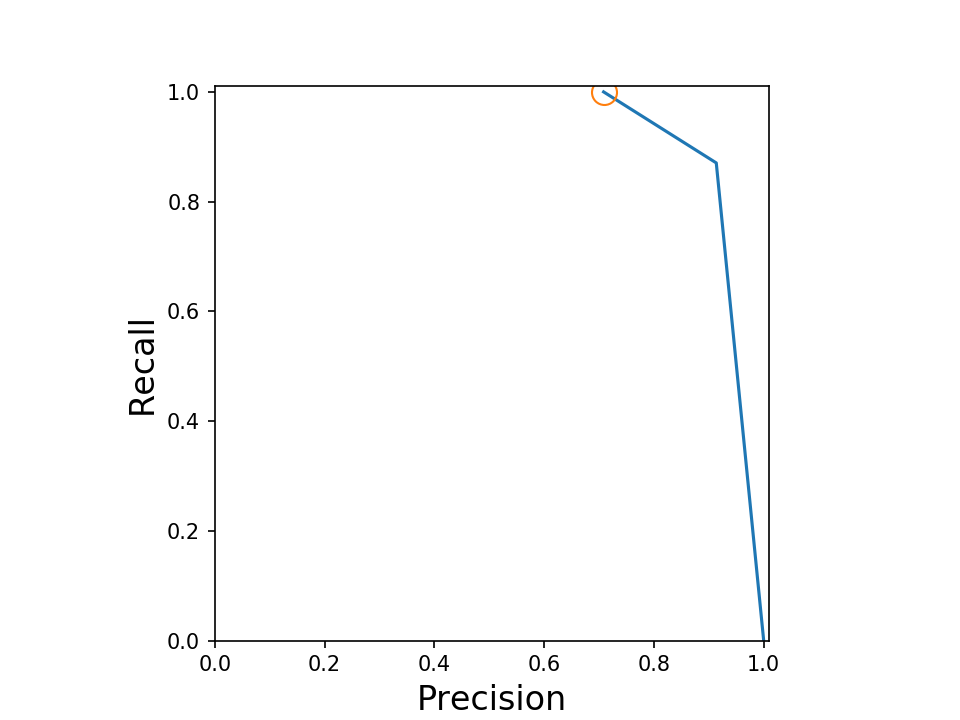

In [144]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>

<IPython.core.display.Javascript object>


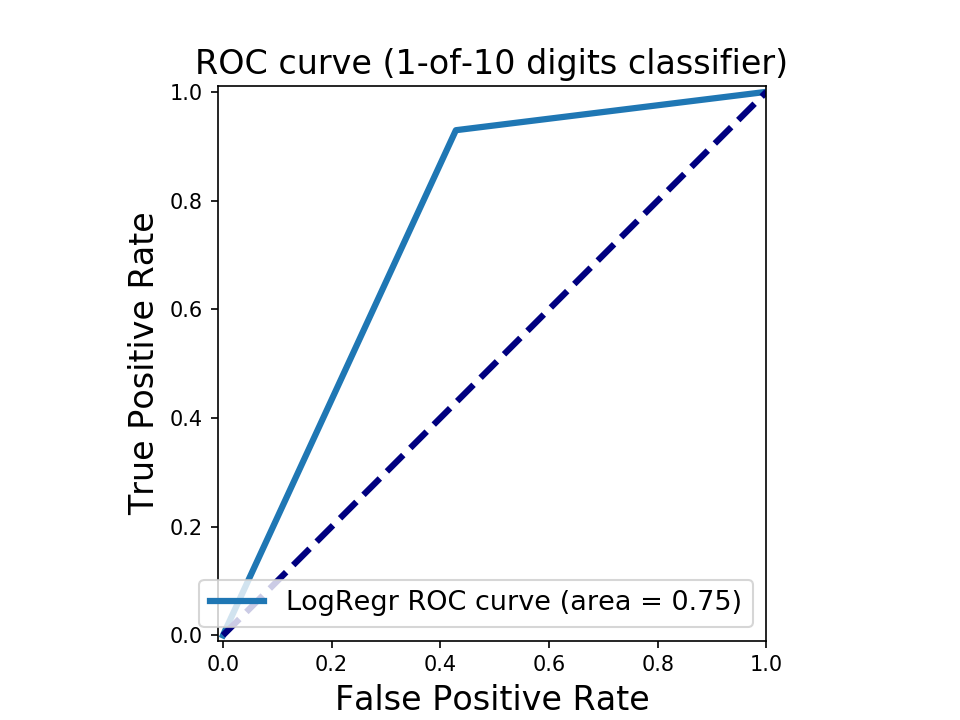

In [145]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

### Building a Random Forest model using PramGrid (Forward Selection) 


In [146]:
from sklearn.ensemble import RandomForestClassifier

max_depth = np.linspace(1, 40, 40, endpoint=True)
n_estimators = [5,10,15,20,30]
criterion = ['entropy', 'gini']

param_grid = dict(max_depth=max_depth, 
                  n_estimators = n_estimators,
                 criterion=criterion)

#model
from sklearn.model_selection import GridSearchCV
forest = RandomForestClassifier()
grid_search = GridSearchCV(forest, param_grid)

#fit best combination of parameters
grid_search.fit(X_train, y_train.ravel())

y_pred = grid_search.predict(X_test)

Train score


In [147]:
grid_search.score(X_train, y_train)

0.9888888888888889

Test score


In [148]:
grid_search.score(X_test, y_test)

0.85

### Evaluating a model

<b>Cross validation: precision, accuracy, recall and f1<b>

In [149]:
from sklearn.model_selection import cross_val_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)
print('Accuracy: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='accuracy', cv=3)))
print('Precision: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='precision', cv=3)))
print('Recall: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='recall', cv=3)))
print('F1: '+ str(cross_val_score(grid_search, X_train, y_train.ravel(), scoring='f1', cv=3)))

Accuracy: [0.85950413 0.83333333 0.86554622]
Precision: [0.93975904 0.90909091 0.87628866]
Recall: [0.86666667 0.91011236 0.94382022]
F1: [0.88095238 0.90607735 0.93406593]


<b>Building a Confusion Metrics<b>

In [150]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[23, 12],
       [ 6, 79]], dtype=int64)

<b>105</b> were predicted right, while <b>15</b> were predicted wrong. 105/120 = <b>0.875</b>

For this particular situation the <b>False Positive Rate</b> is the most important, because it is not an issue that model predicted a failure for a student while he or she passed, but it is an issue if model predicted a "pass" when student will eventually fail.
It is recommended to minimize FPR or <b>to increse Precision</b>

In [151]:
print("False Positive Rate is: {:.2f}".format(1-precision_score(y_test, y_pred)))

False Positive Rate is: 0.13


AUC score

In [152]:
from sklearn.metrics import roc_auc_score
print("Area under the curve score: {:.2f}".format(roc_auc_score(y_test, y_pred)))

Area under the curve score: 0.79


<b>Adding results to a table for summarization in the end</b>

In [153]:
model_name.append("Forward/Random Forest")
accuracy_col.append(accuracy_score(y_test, y_pred))
precision_col.append(precision_score(y_test, y_pred))
recall_col.append(recall_score(y_test, y_pred))
f1_col.append(f1_score(y_test, y_pred))
auc_col.append(roc_auc_score(y_test, y_pred))

<b>Building a precision-recall curve<b>

<IPython.core.display.Javascript object>


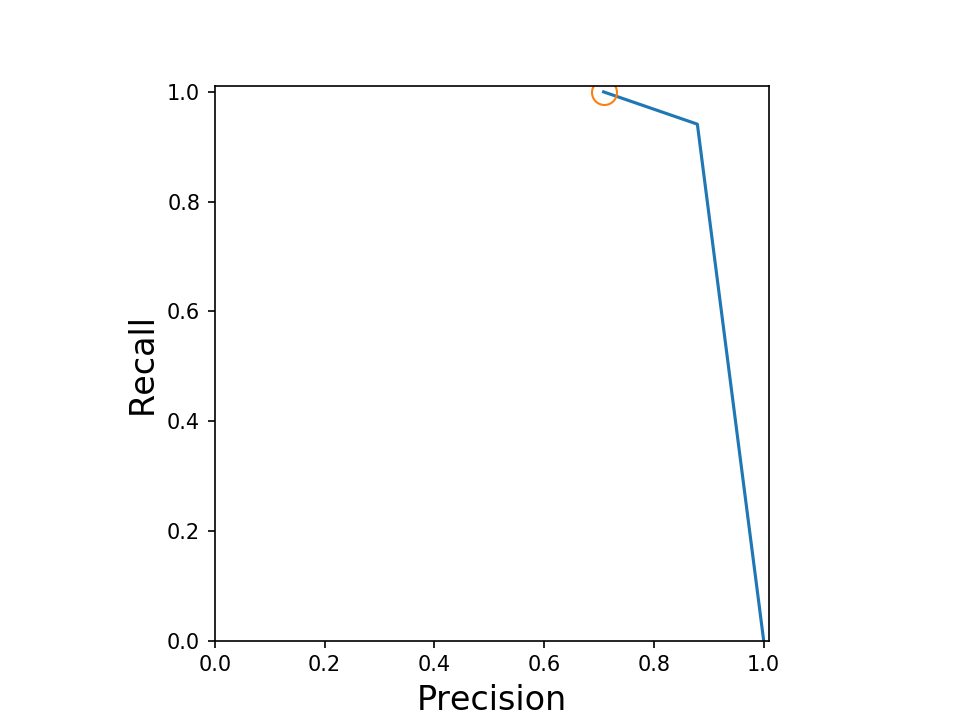

In [154]:
from sklearn.metrics import precision_recall_curve

y_scores_lr = grid_search.fit(X_train, y_train).predict(X_test)
%matplotlib notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none')
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

<b>Building a ROC curve</b>

<IPython.core.display.Javascript object>


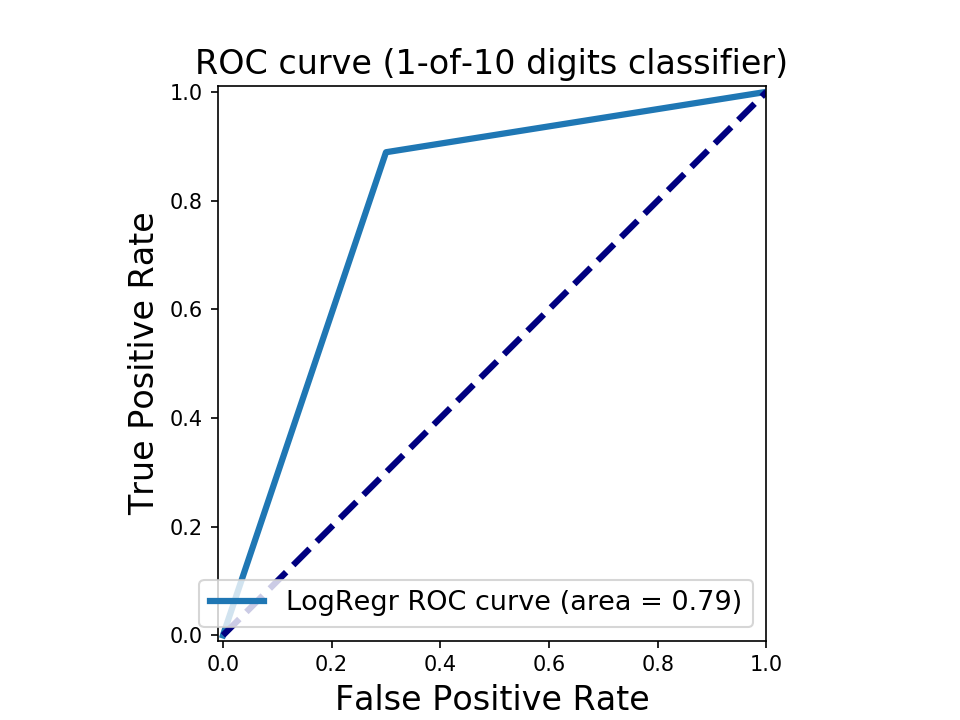

In [155]:
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred_lr = grid_search.fit(X_train, y_train).predict(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

<b>A table to compare results


In [156]:
d = {'model_name': model_name, 'accuracy_col': accuracy_col, 'precision_col': precision_col,
'recall_col': recall_col, 'f1_col': f1_col, 'auc_col': auc_col}
df = pd.DataFrame(data=d)
df

,model_name,accuracy_col,precision_col,recall_col,f1_col,auc_col
0,Backward/KNN,0.908333,0.931818,0.942529,0.937143,0.880355
1,Backward/Bayes,0.883333,0.987805,0.861702,0.920455,0.911620
2,Backward/SVC,0.900000,0.902174,0.965116,0.932584,0.850205
3,Backward/Decision Tree,0.816667,0.914634,0.833333,0.872093,0.800000
4,Backward/Random Forest,0.866667,0.880435,0.941860,0.910112,0.809166
5,Forward/KNN,0.875000,0.891304,0.942529,0.916201,0.819749
6,Forward/Bayes,0.875000,1.000000,0.838710,0.912281,0.919355
7,Forward/SVC,0.875000,0.887640,0.940476,0.913295,0.831349
8,Forward/Decision Tree,0.850000,0.913580,0.870588,0.891566,0.835294
9,Forward/Random Forest,0.850000,0.868132,0.929412,0.897727,0.793277


### Summary

Considering that in this case precision is more important, **bayes** model does the best job in achieving high precision score. Moreover, AUC with bayes is the highest. As of feature selection approach, **Backward Elimination** selected better set of features. The worst model in terms of precision rate is Random Forest